In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.preprocessing import image

In [9]:
IMAGE_SIZE = 250
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names

def sample_dataset(ds, fraction=1/15):
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    sampled_size = int(ds_size * fraction)
    ds = ds.take(sampled_size)
    return ds

dataset = sample_dataset(dataset)

Found 75000 files belonging to 5 classes.


In [11]:
#class_names = dataset.class_names

In [12]:
len(dataset) # Batch quantity 

156

In [13]:
#plt.figure(figsize=(10,10))
#for image_batch, image_label in dataset.take(1):  # Take 1 batch and in shuffle mode(Everytime is diffrent)
    #for i in range(12):
       # ax = plt.subplot(3,4, i+1)
       # plt.imshow(image_batch[i].numpy().astype("uint8"))
       # plt.title(class_names[image_label[i]])
       # plt.axis("off")

In [14]:
# Creating function for split dataset

## In tensorflow there is no ready-func for split so we create one

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
# Calling our func for split

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
# Control

len(train_ds), len(val_ds), len(test_ds)

(124, 15, 17)

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
# Resize and rescale

resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), # Make sure everything in the same size
    layers.Rescaling(1.0/256) # Make every channel rate between 0 and 1
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),  # Daha küçük bir model
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])


model.build(input_shape=input_shape)

/Users/can/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 250, 250, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 250, 250, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 248, 248, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 124, 124, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 122, 122, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 61, 61, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 119072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │    15,241,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 5)                │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,247,077 (58.16 MB)

 Trainable params: 15,247,077 (58.16 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.optimizers import Adam

# Öğrenme oranını azaltarak optimizörü yeniden tanımlayalım
optimizer = Adam(learning_rate=1e-5)  # Öğrenme oranını daha küçük bir değere çekiyoruz

model.compile(
    optimizer=optimizer,
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [16]:
# Train the model

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_ds,
    callbacks=[checkpoint_callback]
)

Epoch 1/50


/Users/can/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-07-25 13:57:05.465966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


124/124 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.5380 - loss: 1.3324 - val_accuracy: 0.9104 - val_loss: 0.7250
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.9055 - loss: 0.6273 - val_accuracy: 0.9187 - val_loss: 0.4217
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - accuracy: 0.9269 - loss: 0.3839 - val_accuracy: 0.9229 - val_loss: 0.3236
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 217ms/step - accuracy: 0.9242 - loss: 0.2931 - val_accuracy: 0.9271 - val_loss: 0.2496
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 219ms/step - accuracy: 0.9428 - loss: 0.2276 - val_accuracy: 0.9375 - val_loss: 0.1976
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - accuracy: 0.9490 - loss: 0.1898 - val_accuracy: 0.9458 - val_loss: 0.1648
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.9496 - loss: 0.1695 - val_accuracy: 0.9604 - val_loss: 0.1433
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - accuracy: 0.9554 - loss: 0.1508 - val

In [17]:
score = model.evaluate(test_ds)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9893 - loss: 0.0405


In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

2024-09-13 23:28:00.894165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 5 of 1000
2024-09-13 23:28:12.167134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 11 of 1000
2024-09-13 23:28:31.152569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 21 of 1000
2024-09-13 23:28:41.920184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 27 of 1000
2024-09-13 23:29:01.086541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 39 of 1000
2024-09-13 23:29:20.386919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 50 o

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-13 23:32:36.863749: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


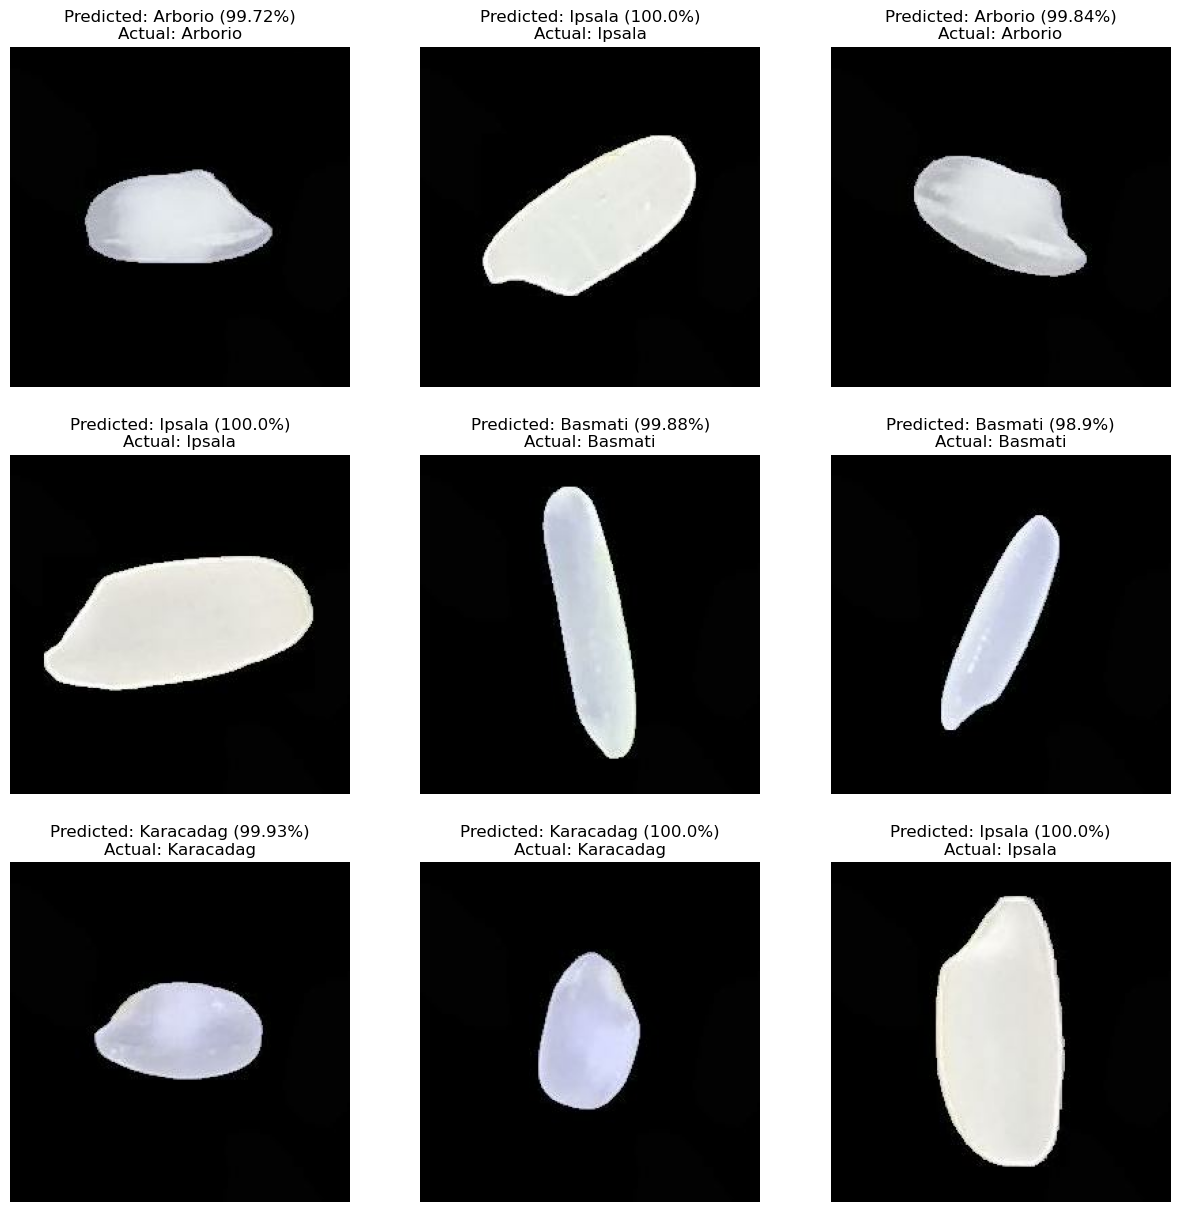

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        
        plt.title(f"Predicted: {predicted_class} ({confidence}%)\nActual: {actual_class}")
        plt.axis('off')

In [22]:
# Model versiyonu
model_version = 1
save_dir = f"./models/{model_version}.keras"

# Klasörün var olup olmadığını kontrol et ve gerekirse oluştur
os.makedirs(os.path.dirname(save_dir), exist_ok=True)

# Modeli kaydet
model.save(save_dir)


In [22]:
# Load the model
model_version = 1
model_path = f"./models/{model_version}.keras"
model = tf.keras.models.load_model(model_path)

